In [1]:
%pylab inline
import h5py
from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import FlatLambdaCDM, z_at_value
import astropy.units as u
import scipy.constants as const

#cosmological parameters from simulation
myfile1='/cosma7/data/Eagle/ScienceRuns/Planck1/L0100N1504/PE/REFERENCE/data/groups_012_z003p017/eagle_subfind_tab_012_z003p017.0.hdf5'
myfile = h5py.File(myfile1, 'r')
H_const = myfile['Header'].attrs['HubbleParam']
Omega0 = myfile['Header'].attrs['Omega0']
z_sim = myfile['Header'].attrs['Redshift']
myfile.close()
cosmo = FlatLambdaCDM(H0 = H_const*100, Om0 = Omega0)

#comoving distance between a galaxy at a certain redshift and the redshift of the simulation
def diff_comoving_distance(z1): 
    return -cosmo.comoving_distance(z_sim).value + cosmo.comoving_distance(z1).value

#inverting the previous function, such that it associates a redshift given a distance to the centre
#of the simulation box (that's why I have -50, so that if a galaxy is at 50 Mpc it's in the middle and
#its redshift is the the redshift of the simulation
def dist_to_redshift(pos): 
    return z_at_value(diff_comoving_distance, pos -50) 

Pos_Mpc_corr = np.genfromtxt('Pos_lumfun.txt')

Populating the interactive namespace from numpy and matplotlib


In [67]:
#limits for a smaller box
lim_inf = 0
lim_sup = 100
L_box = lim_sup-lim_inf
z_inf = dist_to_redshift(lim_inf)
z_sup = dist_to_redshift(lim_sup)
tot_vol = (lim_sup-lim_inf)**3

#selecting galaxies inside a smaller box
ind = []
for i in range(len(Pos_Mpc_corr)):
    if lim_inf<Pos_Mpc_corr[i,0]<lim_sup and lim_inf<Pos_Mpc_corr[i,1]<lim_sup and lim_inf<Pos_Mpc_corr[i,2]<lim_sup:
        ind.append('True')
    else:
        ind.append('False')
ind = np.array(ind)

Pos_Mpc_corr_red = Pos_Mpc_corr[ind=='True'][:]
Ngal = len(Pos_Mpc_corr_red)
print('Number of galaxies inside the box: ', len(Pos_Mpc_corr_red))

#projected distance with boundary conditions
def proj_dist(pos1, pos2):
    dist = np.sqrt((pos1[0]-pos2[0])**2 + (pos1[1]-pos2[1])**2)
    if dist>L_box/2:
        dist = np.abs(dist - L_box)
    return dist

Number of galaxies inside the box:  152496


In [68]:
#extracting random galaxies
random_gal = np.random.randint(0, len(Pos_Mpc_corr_red), 1000)

#defining the bins
bins = np.array([0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 0.75, 1])
Nbins = len(bins)-1
bins_cen = (bins[1:]+bins[:-1])/2
dvol = np.pi*(bins[1:]**2-bins[:-1]**2)*L_box

#array of distances
dd = np.zeros((len(random_gal),len(Pos_Mpc_corr_red)))

for i in range(len(random_gal)):
    for j in range(len(Pos_Mpc_corr_red)):
        dd[i,j] = proj_dist(Pos_Mpc_corr_red[random_gal[i]], Pos_Mpc_corr_red[j])

#number of galaxies in each bin
dens_prof = np.zeros((len(random_gal), Nbins))
for i in range(len(random_gal)):
    for j in dd[i]:
        for k in range(len(bins)-1):
            if bins[k]<j<bins[k+1]:
                dens_prof[i,k] += 1

#normalize by the volume
dens_prof = dens_prof/dvol

#average density profile
av_dens_prof = np.mean(dens_prof, axis=0)

av_density= av_dens_prof/(Ngal/tot_vol)

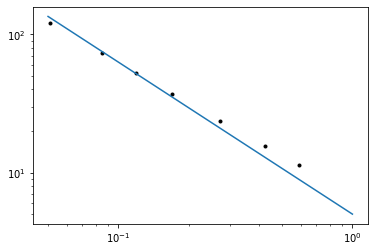

In [75]:
plt.plot(bins_cen*cosmo.h, av_density, '.k')
plt.xscale('log')
plt.yscale('log')

xaxis= np.linspace(bins[0], bins[-1], 10)
plt.plot(xaxis, 5*xaxis**(-1.1))

Text(0.5, 1.0, 'redshift')

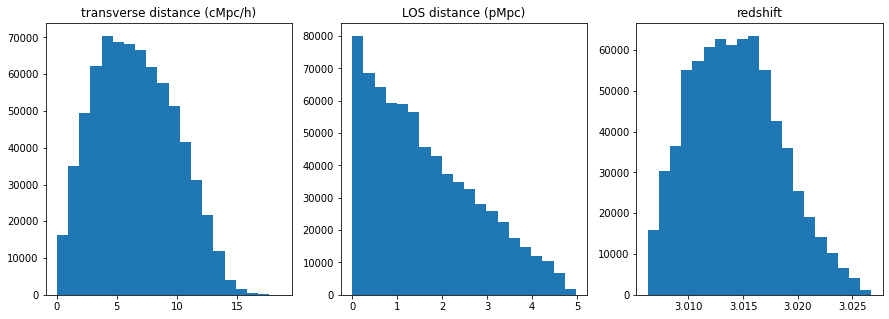

In [4]:
#distribution of the evaluated distances
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].hist(d_DD, bins=20)
ax[0].set_title('transverse distance (cMpc/h)')
ax[1].hist((dv_DD), bins=20)
ax[1].set_title('LOS distance (pMpc)')
ax[2].hist(z_DD, bins=20)
ax[2].set_title('redshift')

In [5]:
###################################
# Define Distances
###################################
# Define the binning in LOS direction
#vmax   = 3000
Nvbin  = 10
# Convert LOS separation from km/s to pMpc
vmin   = 50/cosmo.H(np.mean(zLAE)).value
vlim   = np.max(dv_DD) #np.vmax/cosmo.H(np.mean(zLAE)).value  
# Define log-spaced intervals of distance
dvbin  = np.logspace(np.log10(vmin),np.log10(vlim),Nvbin+1)
# Add a larger bin at the beginning of the array
# where you do not expect to find many sources
dvbin  = np.insert(dvbin,0,4/cosmo.H(np.mean(zLAE)).value)
print('LOS bins [pMpc] ', dvbin)
dvbin_cent = (dvbin[1:]+dvbin[:-1])/2.	# pMpc
xerr   = (dvbin[1:]-dvbin[:-1]) #pMPc bin width

# Upper Integration Limit coinverted from a LOS velocity in km/s into [pMpc]
#vuplim = vlim #500/cosmo.H(np.mean(zLAE)).value	
Nvbin += 1		# Final number of bin

# Define the binning in transverse direction
dbin  = np.array([0.04,0.15,0.25,0.35,0.45,0.60, 0.80, 1.00])  #[cMpc/h]
dbin_cent = (dbin[1:]+dbin[:-1])/2		# [cMpc/h]
Ndbin = len(dbin)-1	# Final number of bin
print('Transverse bins [cMpc/h] ', dbin)

LOS bins [pMpc]  [0.01301927 0.16274084 0.22912043 0.32257528 0.45414898 0.63938965
 0.90018726 1.26736038 1.78429799 2.51208684 3.53673002 4.97931005]
Transverse bins [cMpc/h]  [0.04 0.15 0.25 0.35 0.45 0.6  0.8  1.  ]


In [13]:
xi = 

Starting Bootstrap ...
1/20 [4.19656012 2.73824866 1.61339696 1.48856854 1.66937618 1.04124395
 1.28708987]
2/20 [4.97710641 2.51113725 1.54997512 1.84092048 1.5851147  1.11293923
 1.34198555]
3/20 [4.56371848 2.15609628 1.42941848 1.60139831 1.41704965 1.06462186
 1.14835118]
4/20 [5.06797331 3.09012626 1.8829977  1.80180174 1.62781168 1.31618918
 1.53149507]
5/20 [5.62140133 2.57095824 1.80969168 1.81265851 1.44808865 1.42463394
 1.34138769]
6/20 [5.54435808 2.77781544 1.68148323 1.96042944 1.56526062 1.05367844
 1.25736516]
7/20 [5.62258623 2.21734275 1.51723984 1.76124014 1.46317016 1.17789916
 1.32414985]
8/20 [5.12042506 2.12477926 1.41348494 1.40322835 1.47797242 1.27808238
 1.27422897]
9/20 [5.0083233  2.39229869 1.52368929 1.48415359 1.47880504 1.11819392
 1.04962244]
10/20 [5.2277662  2.73001256 1.29430256 1.80774069 1.468538   1.12073007
 1.23734268]
11/20 [5.13080375 2.52511476 2.15994768 1.6197567  1.73817988 1.16337018
 1.40085545]
12/20 [5.66247065 2.7602956  1.62485943 

In [14]:
print(np.max(dv_DD)*cosmo.H(z_sim))

1531.0324046779365 km / (Mpc s)


In [15]:
print(wGG_boot)

[[4.19656012 2.73824866 1.61339696 1.48856854 1.66937618 1.04124395
  1.28708987]
 [4.97710641 2.51113725 1.54997512 1.84092048 1.5851147  1.11293923
  1.34198555]
 [4.56371848 2.15609628 1.42941848 1.60139831 1.41704965 1.06462186
  1.14835118]
 [5.06797331 3.09012626 1.8829977  1.80180174 1.62781168 1.31618918
  1.53149507]
 [5.62140133 2.57095824 1.80969168 1.81265851 1.44808865 1.42463394
  1.34138769]
 [5.54435808 2.77781544 1.68148323 1.96042944 1.56526062 1.05367844
  1.25736516]
 [5.62258623 2.21734275 1.51723984 1.76124014 1.46317016 1.17789916
  1.32414985]
 [5.12042506 2.12477926 1.41348494 1.40322835 1.47797242 1.27808238
  1.27422897]
 [5.0083233  2.39229869 1.52368929 1.48415359 1.47880504 1.11819392
  1.04962244]
 [5.2277662  2.73001256 1.29430256 1.80774069 1.468538   1.12073007
  1.23734268]
 [5.13080375 2.52511476 2.15994768 1.6197567  1.73817988 1.16337018
  1.40085545]
 [5.66247065 2.7602956  1.62485943 1.72848425 1.51992055 1.18446434
  1.27497909]
 [5.68577259 3.0

[5.33206866 2.49884699 1.61205507 1.66285801 1.53119207 1.15776052
 1.28528646] [0.35863006 0.27039291 0.18754481 0.14993662 0.07859421 0.1195234
 0.09733737]


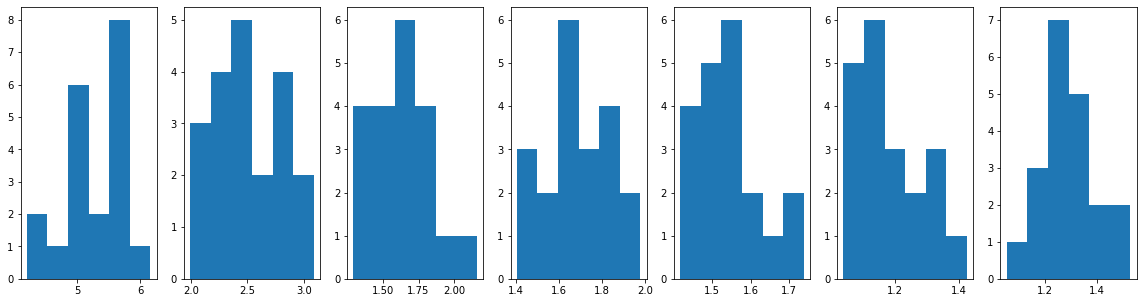

In [20]:
fig, ax = plt.subplots(1,len(wGG_boot[0]), figsize=(20,5))
med = np.zeros((len(ax)))
for i in range(len(ax)):
    ax[i].hist(wGG_boot[:20,i], bins=6)
med = np.median(wGG_boot[:20], axis=0)
sigma = (np.percentile(wGG_boot[:20], 84, axis = 0)  - np.percentile(wGG_boot[:20], 16, axis=0))/2          
print(med, sigma)

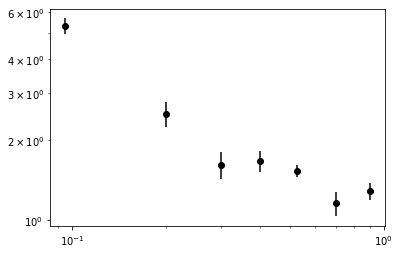

In [21]:
plt.errorbar(dbin_cent, med, sigma, marker='o', ls='', color='black')
plt.xscale('log')
plt.yscale('log')

#x_axis = np.linspace(0.07, 0.6, 10)
#plt.plot(x_axis, 0.04*(2.47/x_axis)**(1.5))

In [53]:
#### comparison with MAGG
w_GG_comp = np.zeros((Nboot, Ndbin))

for i in range(len(fGG_boot)):
    for j in range(Ndbin):
        for k in range(Nvbin):
            if dvbin_cent[k]<500/cosmo.H(z_sim).value:
                w_GG_comp[i,j] += fGG_boot[i,j,k]*xerr[k]
                
med_comp = np.median(w_GG_comp, axis=0)
sigma_comp = (np.percentile(w_GG_comp, 84, axis=0) - np.percentile(w_GG_comp, 16, axis=0))/2

In [54]:
print(dvbin_cent)
print(500/cosmo.H(z_sim).value, 500/cosmo.H(np.mean(zLAE)).value)
print(w_GG_comp)

[0.08788005 0.19593064 0.27584786 0.38836213 0.54676932 0.76978846
 1.08377382 1.52582919 2.14819241 3.02440843 4.25802004]
1.626128238372541 1.627408421285695
[[4.20959119 3.22708018 2.18025175 1.64317416 1.56331298 1.08816382
  0.98286831]
 [4.80099285 2.87742361 2.22608877 1.70183207 1.52833917 1.11833205
  1.03503306]
 [4.58860236 2.98400694 2.04155541 1.70036025 1.47152934 1.12522703
  0.97765625]
 [4.82549918 3.35007326 2.30759537 1.73738492 1.61002939 1.14343335
  1.00302424]
 [5.19190558 2.95554077 2.26033542 1.61801029 1.51565016 1.22131542
  0.96165259]
 [5.19857714 2.92846789 2.2117386  1.78206655 1.53170839 1.06753557
  0.92148781]
 [5.4006971  2.70847465 2.16412512 1.56250084 1.57231887 1.14695683
  0.95602679]
 [4.58516539 2.59688649 2.05750224 1.48653646 1.61547286 1.12834156
  0.97894745]
 [4.9567712  2.67087148 2.38439744 1.60423158 1.60754392 1.15688409
  0.94229581]
 [4.7886556  2.99880792 2.02572391 1.75486543 1.48672198 1.11448585
  0.96586847]
 [4.82405364 2.85353

[0.39869728 0.19512326 0.1624109  0.09034374 0.06254156 0.02591865
 0.02959669]


Text(0.5, 1.0, 'Projected correlation function')

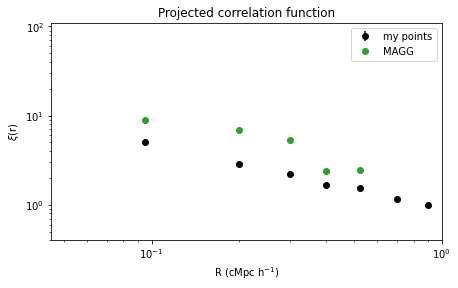

In [64]:
#MAGG comparison
fig = plt.figure(figsize=(7,4))
MAGG_cor = np.genfromtxt('MAGG_LAE_corr.txt')
x_M = MAGG_cor[:,0]
y_M = MAGG_cor[:,1]

plt.errorbar(dbin_cent, med_comp, sigma_comp, marker='o', ls='', color='black', label='my points')
plt.xscale('log')
plt.yscale('log')
print(sigma_comp)
#plt.errorbar(dbin_cent, med, sigma, marker='o', ls='', color='red')

#plt.plot(bin_cent, y_M, '.k')
plt.xlim(0.045,1.00)
plt.ylim(0.4, 110)

plt.errorbar(dbin_cent[:-2], y_M, color='tab:green', marker='o', ls='', label='MAGG')
plt.legend()
plt.xlabel(r'R (cMpc h$^{-1}$)')
plt.ylabel(r'$\xi$(r)')
plt.title('Projected correlation function')